In [11]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#impot seaborn as sns
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import  tqdm
import warnings 
import math 
warnings.filterwarnings('ignore')

#pytorch 
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

#seeds 
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

#set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cpu
Device: cpu


In [19]:
#dataset paths 
AUDIO_DIR = "wmms_audio"
LABELS_CSV = 'wmms_labels.csv'

#audio preocessing parameters 
SAMPLE_RATE = 22050
DURATION = 5
N_FFT =2048
HOP_LENGTH =512
N_FREQ_BINS =128

#training parameters 
BATCH_SIZE= 16 
EPOCHS = 20 
LEARNING_RATE=0.001
VALIDATION_SPLIT =0.2
TEST_SIZE = 0.2

print("configuration set successfully")

configuration set successfully


In [13]:
# Load labels CSV
df = pd.read_csv(LABELS_CSV)

print(f"CSV Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nFirst 10 rows:")
display(df.head(10))

CSV Shape: (1357, 4)

Columns: ['file', 'species', 'label_id', 'duration_sec']

First 10 rows:


,file,species,label_id,duration_sec
0,clip_00000.wav,Spinner_Dolphin,26,NaN
1,clip_00001.wav,Bearded_Seal,1,NaN
2,clip_00002.wav,Weddell_Seal,29,NaN
3,clip_00003.wav,Harp_Seal,11,NaN
4,clip_00004.wav,False_Killer_Whale,7,NaN
5,clip_00005.wav,Frasers_Dolphin,9,NaN
6,clip_00006.wav,Long-Finned_Pilot_Whale,15,NaN
7,clip_00007.wav,"Beluga,_White_Whale",2,NaN
8,clip_00008.wav,Atlantic_Spotted_Dolphin,0,NaN
9,clip_00009.wav,Spinner_Dolphin,26,NaN


In [14]:
# Identify filename and label columns
print("Available columns:")
for i, col in enumerate(df.columns):
    print(f"  {i}: {col}")

# Auto-detect columns (adjust if needed)
filename_col = 'file' if 'file' in df.columns else df.columns[0]
label_col = 'species' if 'species' in df.columns else df.columns[1]

print(f"\nUsing '{filename_col}' as filename column")
print(f"Using '{label_col}' as label column")

Available columns:
  0: file
  1: species
  2: label_id
  3: duration_sec

Using 'file' as filename column
Using 'species' as label column



Number of classes: 32

Class distribution:
species
Spinner_Dolphin                     91
Frasers_Dolphin                     69
Striped_Dolphin                     65
Sperm_Whale                         60
Long-Finned_Pilot_Whale             56
Grampus,_Rissos_Dolphin             54
Pantropical_Spotted_Dolphin         53
Short-Finned_Pacific_Pilot_Whale    53
Humpback_Whale                      51
Clymene_Dolphin                     50
Melon_Headed_Whale                  50
Bowhead_Whale                       48
False_Killer_Whale                  47
White-beaked_Dolphin                46
Atlantic_Spotted_Dolphin            46
White-sided_Dolphin                 44
Northern_Right_Whale                43
Common_Dolphin                      42
Rough-Toothed_Dolphin               40
Fin,_Finback_Whale                  40
Beluga,_White_Whale                 40
Narwhal                             40
Ross_Seal                           40
Harp_Seal                           38
Bearded_Seal

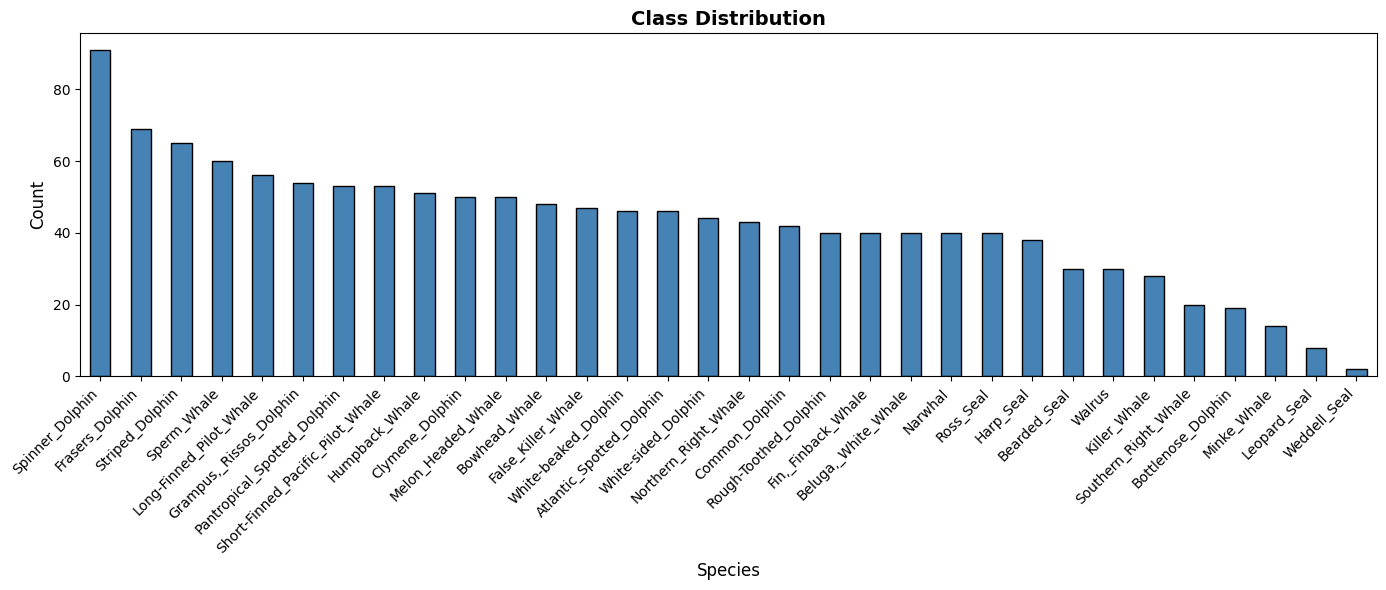


Min samples per class: 2
Max samples per class: 91
Imbalance ratio: 45.50


In [15]:
# Class distribution
class_counts = df[label_col].value_counts()
print(f"\nNumber of classes: {len(class_counts)}")
print(f"\nClass distribution:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Species', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check class imbalance
min_samples = class_counts.min()
max_samples = class_counts.max()
imbalance_ratio = max_samples / min_samples

print(f"\nMin samples per class: {min_samples}")
print(f"Max samples per class: {max_samples}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

In [20]:
def load_audio(audio_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """
    Load audio file and resample if necessary
    
    Args:
        audio_path: Path to audio file
        target_sr: Target sample rate
        duration: Duration in seconds
        
    Returns:
        audio: Audio signal as numpy array
        sr: Sample rate
    """
    try:
        # Load audio using soundfile
        audio, sr = sf.read(audio_path)
        
        # Convert stereo to mono if needed
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
        
        # Resample if necessary
        if sr != target_sr:
            # Calculate number of samples for target sample rate
            num_samples = int(len(audio) * target_sr / sr)
            audio = signal.resample(audio, num_samples)
            sr = target_sr
        
        # Pad or trim to fixed length
        target_length = target_sr * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        return audio, sr
        
    except Exception as e:
        print(f"Error loading {audio_path}: {str(e)}")
        return None, None


def audio_to_spectrogram(audio_path, sample_rate=SAMPLE_RATE, duration=DURATION,
                         n_fft=N_FFT, hop_length=HOP_LENGTH, n_freq_bins=N_FREQ_BINS):
    """
    Convert audio file to spectrogram using scipy.signal.spectrogram
    
    Args:
        audio_path: Path to audio file
        sample_rate: Target sample rate
        duration: Audio duration in seconds
        n_fft: FFT window size
        hop_length: Hop length between windows
        n_freq_bins: Number of frequency bins to keep
        
    Returns:
        Normalized spectrogram as numpy array
    """
    try:
        # Load audio
        audio, sr = load_audio(audio_path, sample_rate, duration)
        
        if audio is None:
            return None
        
        # Calculate noverlap from hop_length
        noverlap = n_fft - hop_length
        
        # Compute spectrogram using scipy
        frequencies, times, Sxx = signal.spectrogram(
            audio,
            fs=sr,
            window='hann',
            nperseg=n_fft,
            noverlap=noverlap,
            nfft=n_fft,
            scaling='density',
            mode='magnitude'
        )
        
        # Keep only the first n_freq_bins frequency bins
        Sxx = Sxx[:n_freq_bins, :]
        
        # Convert to log scale (dB) - add small epsilon to avoid log(0)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Normalize to [0, 1]
        Sxx_norm = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min() + 1e-8)
        
        return Sxx_norm
        
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

print("Audio processing functions defined (using scipy spectrogram)!")

Audio processing functions defined (using scipy spectrogram)!


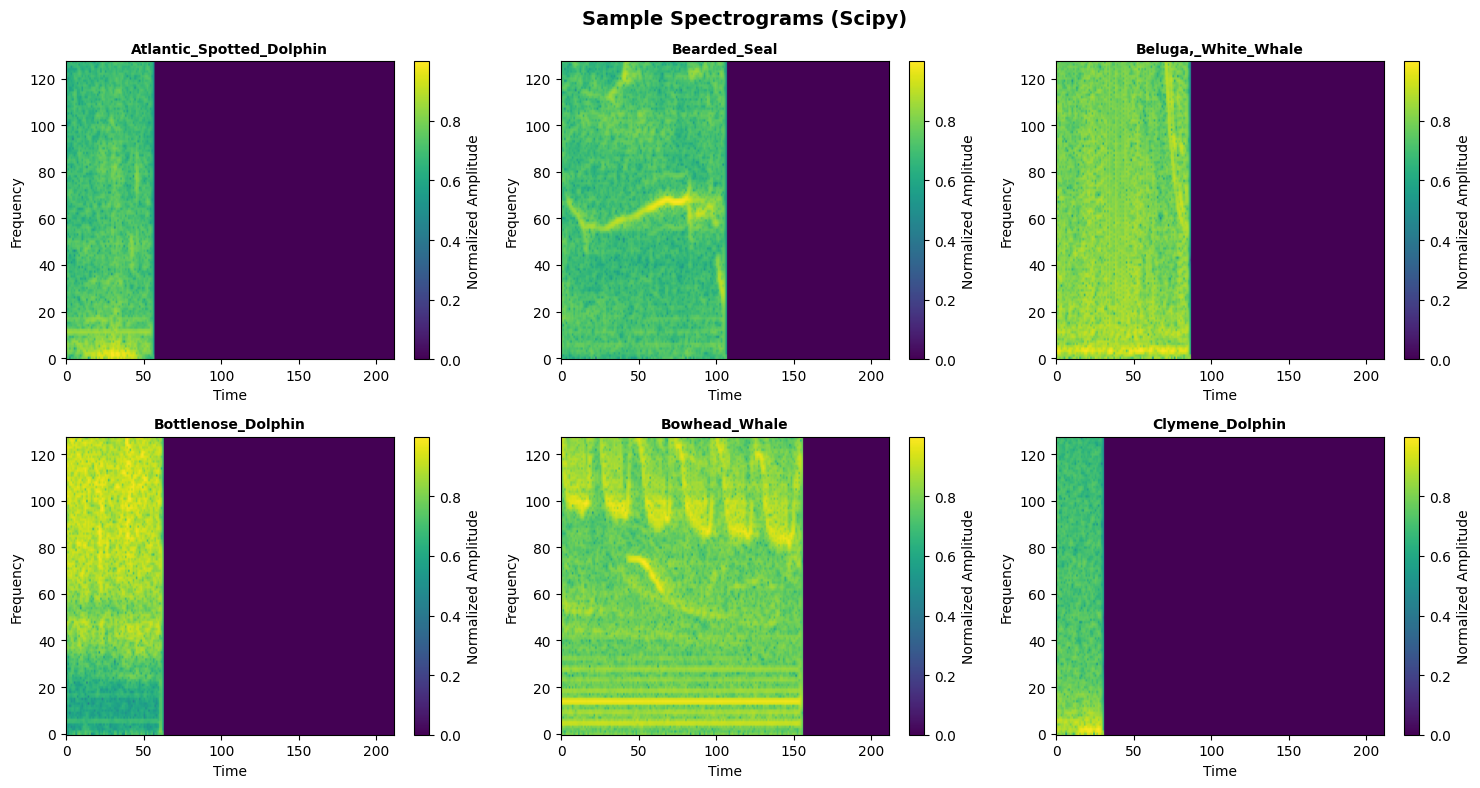

In [21]:
# Get sample files for visualization
sample_files = df.groupby(label_col).first().reset_index()
num_samples = min(6, len(sample_files))

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (idx, row) in enumerate(sample_files.head(num_samples).iterrows()):
    filename = row[filename_col]
    label = row[label_col]
    audio_path = os.path.join(AUDIO_DIR, filename)
    
    if os.path.exists(audio_path):
        spec = audio_to_spectrogram(audio_path)
        if spec is not None:
            im = axes[i].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
            axes[i].set_title(f'{label}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel('Frequency')
            plt.colorbar(im, ax=axes[i], label='Normalized Amplitude')

plt.suptitle('Sample Spectrograms (Scipy)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [22]:
# Load all audio files and convert to spectrograms
print("Loading and processing audio files...")
print("This may take a few minutes depending on dataset size.\n")

X = []
y = []
failed_files = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio"):
    filename = row[filename_col]
    label = row[label_col]
    
    # Try to find the audio file
    audio_path = os.path.join(AUDIO_DIR, filename)
    
    if not os.path.exists(audio_path):
        # Try different extensions
        for ext in ['.wav', '.mp3', '.flac', '.ogg']:
            base_name = os.path.splitext(filename)[0]
            audio_path = os.path.join(AUDIO_DIR, base_name + ext)
            if os.path.exists(audio_path):
                break
    
    if not os.path.exists(audio_path):
        failed_files.append(filename)
        continue
    
    # Convert to spectrogram
    spec = audio_to_spectrogram(audio_path)
    
    if spec is not None:
        X.append(spec)
        y.append(label)

if failed_files:
    print(f"\n Warning: Could not find {len(failed_files)} audio files")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Add channel dimension for CNN (batch, channel, height, width)
X = X[:, np.newaxis, :, :]  # PyTorch expects (N, C, H, W)

print(f"\n{'='*60}")
print("Data Preparation Complete!")
print(f"{'='*60}")
print(f"Total samples loaded: {len(X)}")
print(f"Spectrogram shape: {X.shape}")
print(f"Input shape per sample: {X.shape[1:]}")

Loading and processing audio files...
This may take a few minutes depending on dataset size.



Processing audio: 100%|██████████| 1357/1357 [02:34<00:00,  8.79it/s]



Data Preparation Complete!
Total samples loaded: 1357
Spectrogram shape: (1357, 1, 128, 212)
Input shape per sample: (1, 128, 212)


In [23]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 32
Classes: ['Atlantic_Spotted_Dolphin' 'Bearded_Seal' 'Beluga,_White_Whale'
 'Bottlenose_Dolphin' 'Bowhead_Whale' 'Clymene_Dolphin' 'Common_Dolphin'
 'False_Killer_Whale' 'Fin,_Finback_Whale' 'Frasers_Dolphin'
 'Grampus,_Rissos_Dolphin' 'Harp_Seal' 'Humpback_Whale' 'Killer_Whale'
 'Leopard_Seal' 'Long-Finned_Pilot_Whale' 'Melon_Headed_Whale'
 'Minke_Whale' 'Narwhal' 'Northern_Right_Whale'
 'Pantropical_Spotted_Dolphin' 'Ross_Seal' 'Rough-Toothed_Dolphin'
 'Short-Finned_Pacific_Pilot_Whale' 'Southern_Right_Whale' 'Sperm_Whale'
 'Spinner_Dolphin' 'Striped_Dolphin' 'Walrus' 'Weddell_Seal'
 'White-beaked_Dolphin' 'White-sided_Dolphin']


In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=42, 
    stratify=y_encoded
)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining data shape: {X_train.shape}")

Training set: 868 samples
Validation set: 217 samples
Test set: 272 samples

Training data shape: (868, 1, 128, 212)


In [25]:
class WhaleAudioDataset(Dataset):
    """Custom Dataset for whale audio spectrograms"""
    
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y

# Create datasets
train_dataset = WhaleAudioDataset(X_train, y_train)
val_dataset = WhaleAudioDataset(X_val, y_val)
test_dataset = WhaleAudioDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 55
Validation batches: 14
Test batches: 17


In [ ]:
class WhaleCNN(nn.Module):
    """CNN model for whale audio classification"""
    
    def __init__(self, num_classes, input_height=N_FREQ_BINS, input_width=None):
        super(WhaleCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3, padding=1) #256X212X32
        self.bn1a = nn.BatchNorm2d(32) #256X212X32
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1) #256X212X32
        self.bn1b = nn.BatchNorm2d(32) #256X212X32
        self.pool1 = nn.MaxPool2d(2, 2) #128X212X32
        self.dropout1 = nn.Dropout(0.25)
        
        # Second Convolutional Block
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Third Convolutional Block
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)
        
        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.25)
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 8))
        
        # Fully Connected Layers
        self.flatten_size = 256 * 4 * 8
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Adaptive pooling
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        
        return x

print("CNN Model defined!")

CNN Model defined!
